# San Francisco Crime Prediction with XGBoost

In this notebook, we explore the task of predicting crime categories in San Francisco using machine learning techniques. The dataset used for this analysis contains information about various incidents reported in San Francisco, including details such as time, location, and type of crime. Our goal is to build a predictive model using XGBoost, a popular gradient boosting algorithm, to classify crimes into multiple categories based on historical data. By leveraging machine learning, we aim to contribute to crime prevention efforts and enhance public safety measures in urban areas.

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import joblib
import pickle
import os
import datetime
from sklearn.model_selection import train_test_split
from scipy.stats import f_oneway


In [43]:
# Load the dataset
crime_df = pd.read_csv(r"C:\Users\aksha\OneDrive\Documents\LHL\LHL Assignments\Training Data.csv")


In [44]:
# In the test dataset we only have following columns - Date and Time, DayofWeek, Latitude, Longitude, Address, and District
# Hence in our training set also we will limit the model training to these set of attributes only

# Explore the data

crime_df.head(5)
crime_df = crime_df[['Dates', 'Category', 'DayOfWeek','PdDistrict', 'Address', 'X', 'Y']]
crime_df.head(5)

# Check for missing values
crime_df.isna().sum() # No missing values found

# Check the data type of columns
crime_df.info() 
# Modify the following columns - Dates have to be in date time

# We will derive some fields that can be useful for analysis like time, month and year

crime_df['DT'] = pd.to_datetime(crime_df['Dates'], format = '%m/%d/%Y %H:%M')
crime_df['Month'] = crime_df['DT'].dt.month
crime_df['Year'] = crime_df['DT'].dt.year
crime_df['week_of_month'] = crime_df['DT'].dt.day // 7 + 1
crime_df['day_of_month'] = crime_df['DT'].dt.day
crime_df['hour'] = crime_df['DT'].dt.hour

crime_df = crime_df.drop(columns=['DT', 'Dates'])

crime_df.head(5)

# We can also drop address as the same information is getting captured through lat long and thus 
# this will be a redundant column

crime_df = crime_df.drop(columns=['Address'])

crime_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   DayOfWeek   878049 non-null  object 
 3   PdDistrict  878049 non-null  object 
 4   Address     878049 non-null  object 
 5   X           878049 non-null  float64
 6   Y           878049 non-null  float64
dtypes: float64(2), object(5)
memory usage: 46.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Category       878049 non-null  object 
 1   DayOfWeek      878049 non-null  object 
 2   PdDistrict     878049 non-null  object 
 3   X              878049 non-null  float64
 4   Y              878049 non-null  float64
 5   Month          878049 non-nu

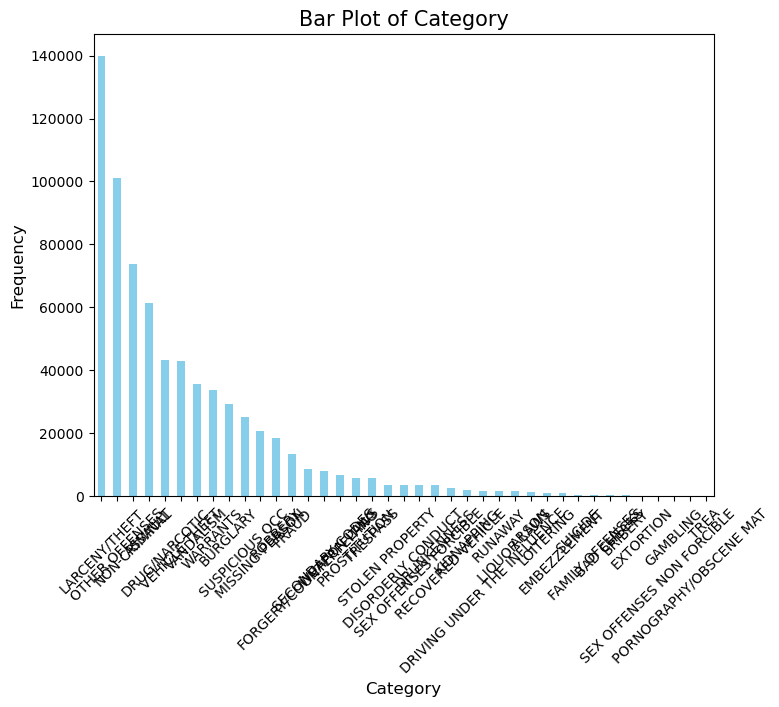

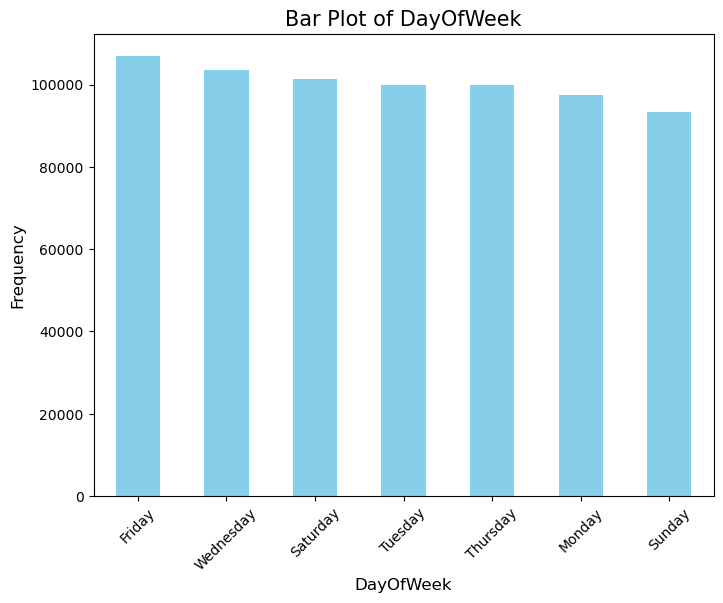

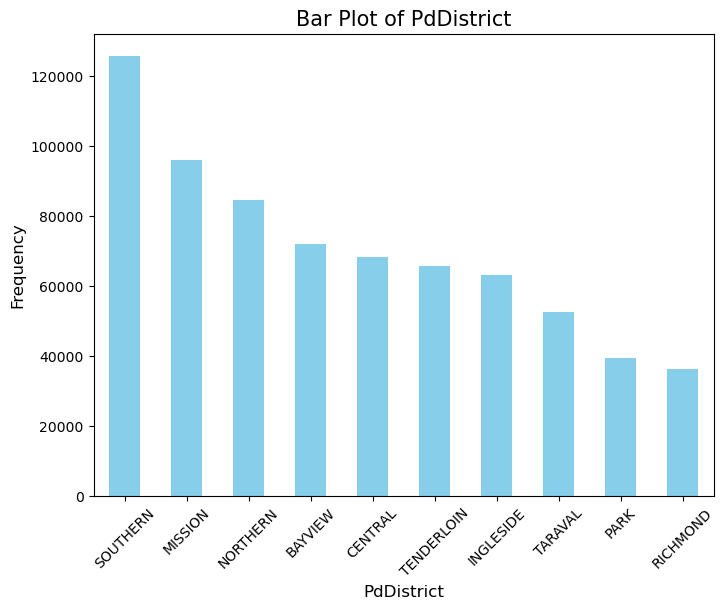

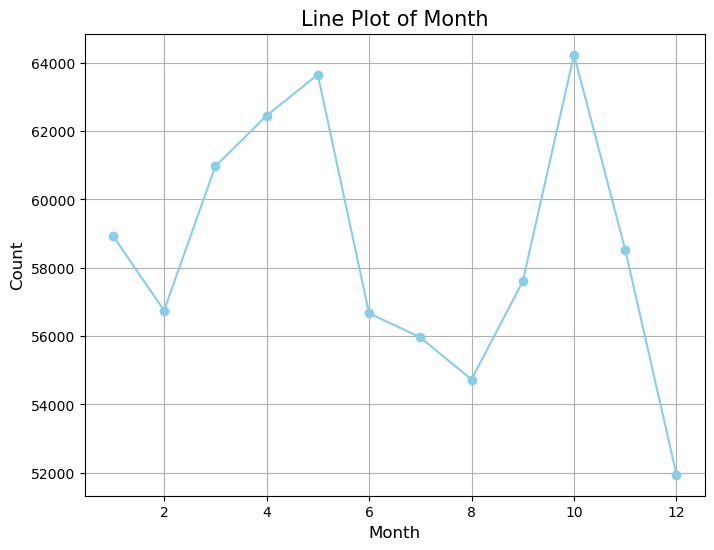

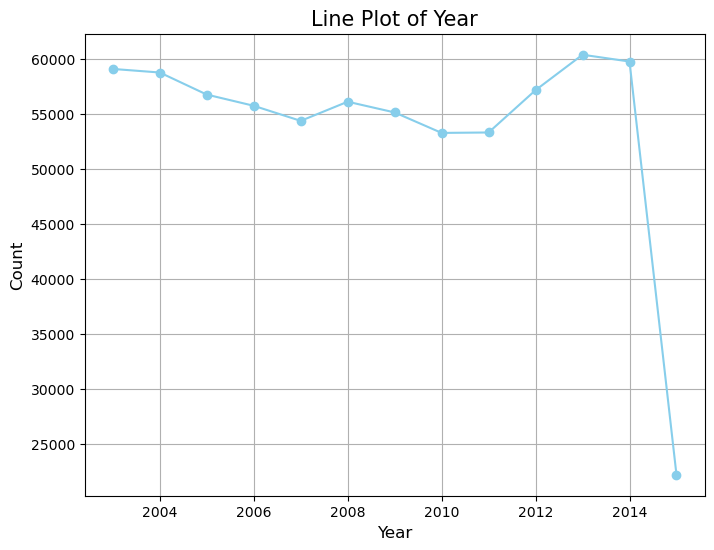

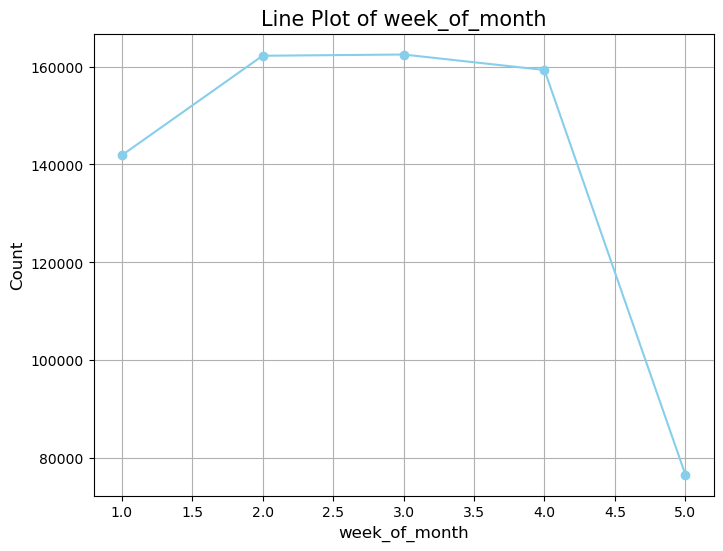

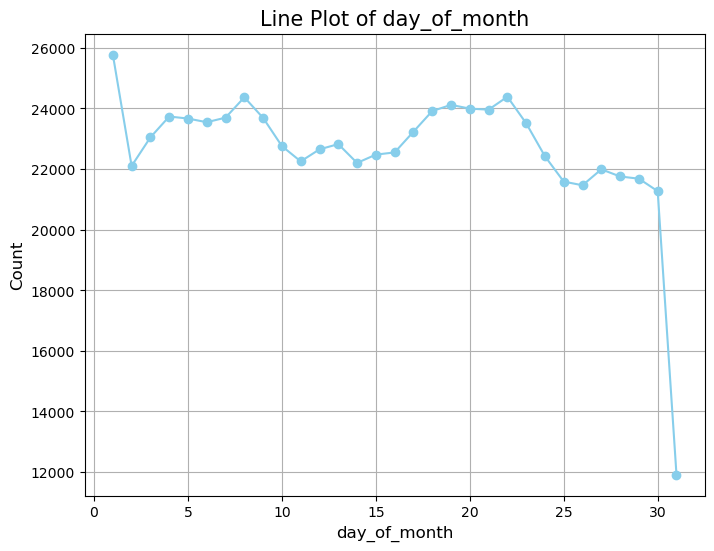

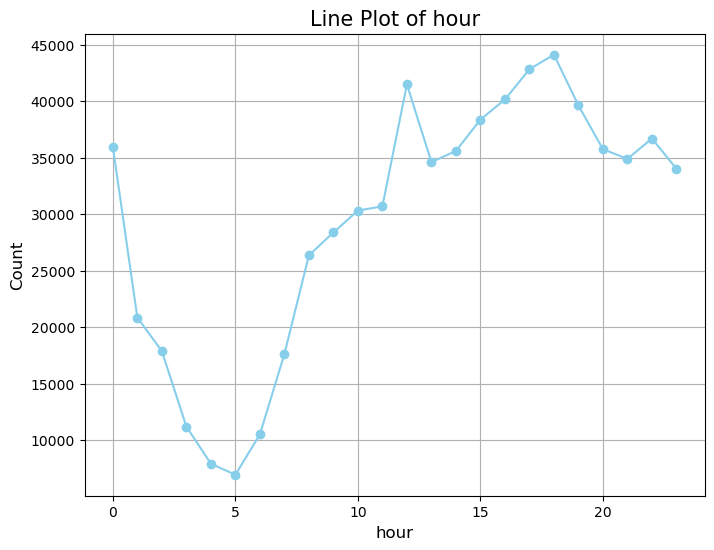

In [52]:
# Now we will divide the dataset into 2 parts - cr_train, cr_test

cr_train, cr_test = train_test_split(crime_df, test_size = 0.2, random_state=42)


# Now we will look at distribution of columns

# Categorical Columns

selected_cols = cr_train.select_dtypes(include=['object', 'category'])

# Plot bar plots in a loop
for col in selected_cols.columns:
    plt.figure(figsize=(8, 6))
    cr_train[col].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Bar Plot of {col}', fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()


# In the Day of week and District the proportion is not very skewed towards one category or the other. 
# Had that been the case then we would have bucketed the categories such that Top 5 District and others
# would have been taken into account.
    
# Subset time related columns and plot their line plots (int32)
numerical_cols = cr_train.select_dtypes(include=['int32'])

# Iterate through numerical columns and build histograms
for col in numerical_cols.columns:
    plt.figure(figsize=(8, 6))
    counts = cr_train[col].value_counts().sort_index()
    plt.plot(counts.index, counts.values, marker='o', color='skyblue')
    plt.title(f'Line Plot of {col}', fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(True)
    plt.show()

# Month - Seasonal pattern observed (Spike between Feb - June duration, 
# with peak observed in May. Another spike observed around October).
# Year - Somewhat similar proportion across years with nominal spikes observed in 2003, 2004 and 2013.
# Week of Month - Spike happens around 2nd week and stays till start of 4th week). 
# Day of Month - High crime rate around first day of the month, 
# post that the distribution is somewhat standard, begins to taper around end of the month (last week).
# Time of day - Higher crime rate is observed between 3 pm to 8 pm.


In [57]:
cr_train.head(5)


,Category,DayOfWeek,PdDistrict,X,Y,Month,Year,week_of_month,day_of_month,hour
81381,NON-CRIMINAL,Wednesday,MISSION,-122.419672,37.765050,4,2014,3,16,6
238545,NON-CRIMINAL,Sunday,MISSION,-122.408831,37.750390,2,2012,4,26,10
823641,VEHICLE THEFT,Saturday,TARAVAL,-122.475536,37.756153,9,2003,3,20,19
497355,ASSAULT,Tuesday,TENDERLOIN,-122.415508,37.781654,5,2008,2,13,13
484193,DRUG/NARCOTIC,Monday,TENDERLOIN,-122.412971,37.785788,7,2008,4,21,18


In [61]:
# Now we will conduct statistical tests to check for feature selection

# Welch Anova Test for Numerical Columns

results = []

numerical_cols = cr_train.select_dtypes(include=['int32']).columns

# Iterate through numerical columns
for col in numerical_cols:
    # Perform Welch's ANOVA test
    f_statistic, p_value = f_oneway(*[group[col] for name, group in cr_train.groupby('Category')])
    
    # Append results to the list
    results.append({'Numerical_Column': col, 'F-statistic': f_statistic, 'p-value': p_value})

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)

  Numerical_Column  F-statistic       p-value
0            Month    14.464648  6.462745e-92
1             Year   384.780556  0.000000e+00
2    week_of_month    12.236163  7.660260e-75
3     day_of_month    14.140675  2.020194e-89
4             hour   302.852667  0.000000e+00


In [62]:
from scipy.stats import chi2_contingency


categorical_columns = cr_train.select_dtypes(include=['object']).columns


# Iterate through each categorical column
for column in categorical_columns:
    # Create a contingency table for the current column and 'Category'
    contingency_table = pd.crosstab(index=cr_train[column], columns=cr_train['Category'])

    # Perform chi-square test for independence
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    # Interpret results
    print(f"Chi-square test results for {column}:")
    print(f"  Chi-square statistic: {chi2}")
    print(f"  p-value: {p_value}")
    if p_value < 0.05:
        print("  There is a significant relationship between", column, "and Category.")
    else:
        print("  There is no significant relationship between", column, "and Category.")
    print()

Chi-square test results for Category:
  Chi-square statistic: 26692682.0
  p-value: 0.0
  There is a significant relationship between Category and Category.

Chi-square test results for DayOfWeek:
  Chi-square statistic: 4869.174011925266
  p-value: 0.0
  There is a significant relationship between DayOfWeek and Category.

Chi-square test results for PdDistrict:
  Chi-square statistic: 100137.46381313082
  p-value: 0.0
  There is a significant relationship between PdDistrict and Category.



We can see that all the variables have a significant association with the crime category

Now we will build our ML model

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


df = crime_df

X = df[['DayOfWeek', 'PdDistrict', 'X', 'Y', 'Month', 'Year', 'week_of_month', 'day_of_month', 'hour']]
y = df['Category']

# Convert categorical variables into numerical format
label_encoders = {}
for column in ['DayOfWeek', 'PdDistrict']:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into train and test sets (stratified split)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# Initialize XGBoost classifier with class weights
xgb_classifier = XGBClassifier(class_weight=class_weights_dict)

# Train the model
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_classifier.predict(X_test)

# Decode the integer predictions back to string labels
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Convert y_test to string labels for consistency
y_test_str = label_encoder.inverse_transform(y_test)

# Compute accuracy metrics using the string labels
accuracy = accuracy_score(y_test_str, y_pred_decoded)
precision = precision_score(y_test_str, y_pred_decoded, average='weighted')
recall = recall_score(y_test_str, y_pred_decoded, average='weighted')
f1 = f1_score(y_test_str, y_pred_decoded, average='weighted')
classification_rep = classification_report(y_test_str, y_pred_decoded)


# Print accuracy metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Classification Report:\n", classification_rep)

In [70]:
df = crime_df

# Separate features (X) and target variable (y)
X = df[['DayOfWeek', 'PdDistrict', 'X', 'Y', 'Month', 'Year', 'week_of_month', 'day_of_month', 'hour']]
y = df['Category']

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['DayOfWeek', 'PdDistrict'])

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(zip(label_encoder.transform(label_encoder.classes_), class_weights))

# Initialize XGBoost classifier with class weights
xgb_classifier = XGBClassifier(class_weight=class_weights_dict)

# Retrain the model on the entire dataset
xgb_classifier.fit(X, y_encoded)

# Save the model to a file
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_classifier, f)

c:\Users\aksha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


In [71]:
# Test Set Prediction

crime_df = pd.read_csv(r"C:\Users\aksha\OneDrive\Documents\LHL\LHL Assignments\Test_Data.csv")


In [72]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Id          884262 non-null  int64  
 1   Dates       884262 non-null  object 
 2   DayOfWeek   884262 non-null  object 
 3   PdDistrict  884262 non-null  object 
 4   Address     884262 non-null  object 
 5   X           884262 non-null  float64
 6   Y           884262 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 47.2+ MB


In [73]:
crime_df['DT'] = pd.to_datetime(crime_df['Dates'], format = '%m/%d/%Y %H:%M')
crime_df['Month'] = crime_df['DT'].dt.month
crime_df['Year'] = crime_df['DT'].dt.year
crime_df['week_of_month'] = crime_df['DT'].dt.day // 7 + 1
crime_df['day_of_month'] = crime_df['DT'].dt.day
crime_df['hour'] = crime_df['DT'].dt.hour
crime_df = crime_df.drop(columns=['DT', 'Dates'])
crime_df = crime_df.drop(columns=['Address'])

X = crime_df[['DayOfWeek', 'PdDistrict', 'X', 'Y', 'Month', 'Year', 'week_of_month', 'day_of_month', 'hour']]

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['DayOfWeek', 'PdDistrict'])

# Make predictions on the new dataset
predictions_proba = xgb_classifier.predict_proba(X)

output_df = pd.DataFrame(predictions_proba, columns=label_encoder.classes_)
output_df.insert(0, 'Id', crime_df['Id'])

# Save the predictions to a CSV file
output_df.to_csv('predictions.csv', index=False)
